# Initialization

In [ ]:
!pip install catboost -q
!pip install shap -q

     |████████████████████████████████| 76.3 MB 1.4 MB/s 
     |████████████████████████████████| 564 kB 21.6 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn import metrics
from imblearn import over_sampling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, roc_auc_score, accuracy_score, f1_score 
from scipy import stats
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, reset_parameter

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/darnellkikoo/Dautomation/main/Datasets/Churn_Modelling_Raw.csv')

In [ ]:
nums = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
cats = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited']

In [ ]:
df.sample(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
3587,3588,15599410,Stanley,721,France,Male,41,2,0.00,2,1,0,168219.75,0
6757,6758,15766667,Langler,717,Spain,Male,36,2,102989.83,2,0,1,49185.57,0
8544,8545,15567725,Kodilinyechukwu,689,France,Female,46,7,52016.08,2,1,1,72993.65,0
5411,5412,15813640,Shih,642,France,Female,40,7,0.00,2,1,0,10712.82,0
5539,5540,15790067,Sun,614,Spain,Male,39,3,151914.93,1,0,0,56459.45,0


# Data Preprocessing

## Drop Unused Columns

In [ ]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)
df.sample(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9044,560,Spain,Male,47,1,0.00,1,0,0,128882.66,1
4270,623,France,Female,57,7,71481.79,2,1,1,84421.34,0
8672,706,France,Male,38,1,0.00,2,1,0,122379.54,0
6600,505,France,Female,36,2,79951.90,1,0,1,174123.16,1
5440,690,Germany,Male,43,2,166522.78,1,0,0,119644.59,1


## Recast Data Types

In [ ]:
df['Geography'] = df['Geography'].astype(object)
df['Gender'] = df['Gender'].astype(object)
df['CreditScore'] = df['CreditScore'].astype(float)

In [ ]:
df_new = pd.get_dummies(df)
df_new

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619.0,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608.0,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502.0,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699.0,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850.0,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771.0,39,5,0.00,2,1,0,96270.64,0,1,0,0,0,1
9996,516.0,35,10,57369.61,1,1,1,101699.77,0,1,0,0,0,1
9997,709.0,36,7,0.00,1,0,1,42085.58,1,1,0,0,1,0
9998,772.0,42,3,75075.31,2,1,0,92888.52,1,0,1,0,0,1


In [ ]:
df_new.dtypes

CreditScore          float64
Age                    int64
Tenure                 int64
Balance              float64
NumOfProducts          int64
HasCrCard              int64
IsActiveMember         int64
EstimatedSalary      float64
Exited                 int64
Geography_France       uint8
Geography_Germany      uint8
Geography_Spain        uint8
Gender_Female          uint8
Gender_Male            uint8
dtype: object

## Remove Outliers

In [ ]:
print('before: ', len(df_new))

filter = np.array([True] * len(df_new))

for col in nums:
  zscore = abs(stats.zscore(df_new[col]))
  filter = (zscore < 3) & (filter)

df_new = df_new[filter]

print('after: ', len(df_new))

before:  10000
after:  9799


In [ ]:
print('before: ', len(df_new))

filter = np.array([True] * len(df_new))

for col in nums:
  q1 = df_new[col].quantile(0.25)
  q3 = df_new[col].quantile(0.75)
  iqr = q3 - q1
  low = q1 - (1.5 * iqr)
  high = q3 + (1.5 * iqr)
  filter = (df_new[col] >= low) & (df_new[col] <= high) & (filter)

df_new = df_new[filter]

print('after: ', len(df_new))

before:  9799
after:  9405


## Normalization & Standardization

In [ ]:
for col in ['Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'CreditScore']:
  df_new[col] = MinMaxScaler().fit_transform(df_new[col].values.reshape(len(df_new), 1))

In [ ]:
X = df_new.copy().drop(['Exited'], axis = 1)
y = df_new['Exited'].copy()

## Divide and Split Datasets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 19, test_size = 0.2, stratify = y)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7524, 13)
(7524,)
(1881, 13)
(1881,)


In [ ]:
y_test.value_counts()

0    1517
1     364
Name: Exited, dtype: int64

In [ ]:
y_train.value_counts()

0    6067
1    1457
Name: Exited, dtype: int64

# Modelling

## Base Models

In [ ]:
models = {
    "Logistic Regression" : LogisticRegression(random_state = 0),
    "LDA" : LinearDiscriminantAnalysis(),
    "KNN" : KNeighborsClassifier(n_neighbors=3), 
    "Gaussian": GaussianNB(),
    "SVC" : SVC(random_state = 0),           
    "Decision Tree": DecisionTreeClassifier(random_state = 0),
    "SGD" : SGDClassifier(random_state = 0),    
    "Random Forest" : RandomForestClassifier(random_state = 0),   
    "Gradient Boosting" : GradientBoostingClassifier(random_state = 0),
    "Adaboost" : AdaBoostClassifier(random_state = 0),
    "XGBoost" : XGBClassifier(random_state = 0),
    "CatBoost" : CatBoostClassifier(random_state = 0, ),
    "LGBM" : LGBMClassifier(random_state = 0),
        }

### Cross Validation

In [ ]:
def Cross_Validation(models):
  scores = []
  scoring = ['recall', 'precision', 'roc_auc', 'f1', 'accuracy']
  for model in models:
    print("Model " +model + " score:")
    classifier = models[model]
    predict_score = cross_validate(classifier, X_train, y_train, scoring = scoring, cv = 5)
    scores.append([
                  model,
                  predict_score['test_recall'].mean(),
                  predict_score['test_precision'].mean(),
                  predict_score['test_roc_auc'].mean(),
                  predict_score['test_f1'].mean(),
                  predict_score['test_accuracy'].mean(),                                                   
    ])  
  b1 = pd.DataFrame(scores)
  b1 = b1.rename({0:'Model', 1: 'Recall', 2: 'Precision', 3: 'ROC AUC', 4: 'F1', 5: 'Accuracy'}, axis = 1)
  b1 = b1.sort_values('Recall', ascending=False).reset_index().drop('index', axis = 1)
  return b1

In [ ]:
Cross_Validation(models)

Streaming output truncated to the last 5000 lines.
5:	learn: 0.6000248	total: 84.1ms	remaining: 13.9s
6:	learn: 0.5863831	total: 90.8ms	remaining: 12.9s
7:	learn: 0.5735872	total: 96.9ms	remaining: 12s
8:	learn: 0.5641220	total: 103ms	remaining: 11.3s
9:	learn: 0.5518484	total: 138ms	remaining: 13.6s
10:	learn: 0.5413791	total: 144ms	remaining: 12.9s
11:	learn: 0.5331868	total: 154ms	remaining: 12.7s
12:	learn: 0.5232898	total: 163ms	remaining: 12.4s
13:	learn: 0.5153477	total: 168ms	remaining: 11.8s
14:	learn: 0.5061646	total: 179ms	remaining: 11.7s
15:	learn: 0.4995426	total: 183ms	remaining: 11.3s
16:	learn: 0.4918003	total: 195ms	remaining: 11.3s
17:	learn: 0.4837246	total: 205ms	remaining: 11.2s
18:	learn: 0.4773904	total: 213ms	remaining: 11s
19:	learn: 0.4713813	total: 228ms	remaining: 11.2s
20:	learn: 0.4642138	total: 243ms	remaining: 11.3s
21:	learn: 0.4588253	total: 253ms	remaining: 11.2s
22:	learn: 0.4536974	total: 266ms	remaining: 11.3s
23:	learn: 0.4481718	total: 274ms	rem

,Model,Recall,Precision,ROC AUC,F1,Accuracy
0,Decision Tree,0.500346,0.470462,0.682512,0.484730,0.794124
1,LGBM,0.458466,0.703398,0.851563,0.554990,0.857522
2,CatBoost,0.452297,0.719691,0.856423,0.555388,0.859782
3,Adaboost,0.428951,0.702448,0.837661,0.532403,0.854200
4,Gradient Boosting,0.427569,0.738822,0.854763,0.541552,0.859915
5,XGBoost,0.421395,0.743975,0.854658,0.537843,0.859916
6,Random Forest,0.415906,0.730975,0.845087,0.530121,0.857257
7,Gaussian,0.385706,0.557908,0.798912,0.455878,0.821636
8,KNN,0.368566,0.568581,0.735882,0.447175,0.823499
9,LDA,0.308153,0.632193,0.790986,0.413724,0.830941


### Test Set

In [ ]:
def Test_Set(models):
  b2 = pd.DataFrame({
      'Model': [ ],
      'Recall': [ ], 
      'Precision': [ ], 
      'ROC_AUC': [ ], 
      'F1': [ ], 
      'Accuracy': [ ]})
  for model in models:
        models[model].fit(X_train, y_train)
        y_pred = models[model].predict(X_test)

        method = model
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision =  precision_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)

        b2 = b2.append({'Model': method,
                        'Recall': recall,
                        'Precision': precision,
                        'ROC_AUC': roc_auc,
                        'F1': f1,
                        'Accuracy': accuracy}, ignore_index = True)
  return b2.sort_values(['Recall'], ascending = False).reset_index().drop('index', axis = 1)

In [ ]:
Test_Set(models)

Learning rate set to 0.024388
0:	learn: 0.6748740	total: 2.32ms	remaining: 2.32s
1:	learn: 0.6574686	total: 5.54ms	remaining: 2.76s
2:	learn: 0.6412274	total: 8.94ms	remaining: 2.97s
3:	learn: 0.6263429	total: 12.2ms	remaining: 3.03s
4:	learn: 0.6111645	total: 14.6ms	remaining: 2.9s
5:	learn: 0.5971793	total: 17ms	remaining: 2.82s
6:	learn: 0.5826605	total: 20.2ms	remaining: 2.86s
7:	learn: 0.5688116	total: 23.4ms	remaining: 2.9s
8:	learn: 0.5547814	total: 26.5ms	remaining: 2.92s
9:	learn: 0.5431650	total: 29.8ms	remaining: 2.95s
10:	learn: 0.5316145	total: 32.9ms	remaining: 2.96s
11:	learn: 0.5206658	total: 36.1ms	remaining: 2.97s
12:	learn: 0.5102610	total: 39.3ms	remaining: 2.98s
13:	learn: 0.5000338	total: 42.5ms	remaining: 2.99s
14:	learn: 0.4913008	total: 45.6ms	remaining: 3s
15:	learn: 0.4829950	total: 48.9ms	remaining: 3s
16:	learn: 0.4761780	total: 52.1ms	remaining: 3.02s
17:	learn: 0.4689006	total: 55.3ms	remaining: 3.02s
18:	learn: 0.4629291	total: 58.6ms	remaining: 3.02s
19

,Model,Recall,Precision,ROC_AUC,F1,Accuracy
0,Decision Tree,0.469780,0.447644,0.665345,0.458445,0.785221
1,CatBoost,0.456044,0.768519,0.711542,0.572414,0.868155
2,LGBM,0.436813,0.750000,0.700938,0.552083,0.862839
3,XGBoost,0.425824,0.786802,0.699069,0.552585,0.866560
4,Random Forest,0.423077,0.754902,0.695059,0.542254,0.861776
5,Gradient Boosting,0.409341,0.788360,0.691486,0.538879,0.864434
6,Adaboost,0.401099,0.741117,0.683740,0.520499,0.856991
7,Gaussian,0.395604,0.580645,0.663524,0.470588,0.827751
8,KNN,0.335165,0.523605,0.630997,0.408710,0.812334
9,SVC,0.299451,0.819549,0.641815,0.438632,0.851675


## Weighted Models

In [ ]:
scale_pos_weight = y_train.value_counts()[0]/y_train.value_counts()[1]
class_weight = {0: 1, 1: y_train.value_counts()[0]/y_train.value_counts()[1]}

In [ ]:
weighted_models = {
    "Logistic Regression" : LogisticRegression(random_state = 0, class_weight = class_weight),
    "LDA" : LinearDiscriminantAnalysis(),
    "KNN" : KNeighborsClassifier(n_neighbors=3), 
    "Gaussian": GaussianNB(),
    "SVC" : SVC(random_state = 0, class_weight = class_weight),           
    "Decision Tree": DecisionTreeClassifier(random_state = 0, class_weight = class_weight),
    "SGD" : SGDClassifier(random_state = 0, class_weight = class_weight),    
    "Random Forest" : RandomForestClassifier(random_state = 0, class_weight = class_weight),   
    "Gradient Boosting" : GradientBoostingClassifier(random_state = 0),
    "Adaboost" : AdaBoostClassifier(random_state = 0),
    "XGBoost" : XGBClassifier(random_state = 0, scale_pos_weight = scale_pos_weight),
    "CatBoost" : CatBoostClassifier(random_state = 0, scale_pos_weight = scale_pos_weight),
    "LGBM" : LGBMClassifier(random_state = 0, scale_pos_weight = scale_pos_weight),
        }

### Cross Validation

In [ ]:
Cross_Validation(weighted_models)

Streaming output truncated to the last 5000 lines.
5:	learn: 0.6391870	total: 17.7ms	remaining: 2.92s
6:	learn: 0.6313776	total: 20.5ms	remaining: 2.91s
7:	learn: 0.6241096	total: 23.4ms	remaining: 2.9s
8:	learn: 0.6165909	total: 26.3ms	remaining: 2.9s
9:	learn: 0.6097573	total: 29.3ms	remaining: 2.9s
10:	learn: 0.6032147	total: 32.2ms	remaining: 2.89s
11:	learn: 0.5984967	total: 34.6ms	remaining: 2.85s
12:	learn: 0.5940071	total: 37.5ms	remaining: 2.85s
13:	learn: 0.5875650	total: 40.4ms	remaining: 2.84s
14:	learn: 0.5822372	total: 43.3ms	remaining: 2.84s
15:	learn: 0.5779278	total: 46.2ms	remaining: 2.84s
16:	learn: 0.5738424	total: 49.1ms	remaining: 2.84s
17:	learn: 0.5705135	total: 52ms	remaining: 2.83s
18:	learn: 0.5654775	total: 54.8ms	remaining: 2.83s
19:	learn: 0.5610347	total: 57.8ms	remaining: 2.83s
20:	learn: 0.5581196	total: 60.7ms	remaining: 2.83s
21:	learn: 0.5549514	total: 63.2ms	remaining: 2.81s
22:	learn: 0.5513912	total: 66.3ms	remaining: 2.81s
23:	learn: 0.5484184	to

,Model,Recall,Precision,ROC AUC,F1,Accuracy
0,XGBoost,0.739201,0.478102,0.854948,0.580443,0.793063
1,SGD,0.726089,0.379385,0.783339,0.493712,0.711319
2,SVC,0.715850,0.462457,0.836147,0.561761,0.783892
3,Logistic Regression,0.711714,0.390575,0.791244,0.504198,0.728866
4,LGBM,0.689764,0.520654,0.849728,0.593286,0.816987
5,CatBoost,0.689091,0.514766,0.853888,0.589131,0.814062
6,Decision Tree,0.469472,0.462238,0.669217,0.465787,0.791602
7,Adaboost,0.428951,0.702448,0.837661,0.532403,0.854200
8,Gradient Boosting,0.427569,0.738822,0.854763,0.541552,0.859915
9,Random Forest,0.396691,0.747297,0.844518,0.518144,0.857124


### Test Set

In [ ]:
Test_Set(weighted_models)

Learning rate set to 0.024388
0:	learn: 0.6837763	total: 2.52ms	remaining: 2.52s
1:	learn: 0.6741511	total: 6.13ms	remaining: 3.06s
2:	learn: 0.6629021	total: 9.62ms	remaining: 3.2s
3:	learn: 0.6524026	total: 13.1ms	remaining: 3.26s
4:	learn: 0.6435346	total: 16.3ms	remaining: 3.25s
5:	learn: 0.6353701	total: 19.8ms	remaining: 3.27s
6:	learn: 0.6277395	total: 22.9ms	remaining: 3.25s
7:	learn: 0.6207772	total: 26.3ms	remaining: 3.27s
8:	learn: 0.6144133	total: 29.7ms	remaining: 3.27s
9:	learn: 0.6065598	total: 33.1ms	remaining: 3.27s
10:	learn: 0.6006347	total: 36.6ms	remaining: 3.29s
11:	learn: 0.5943343	total: 40ms	remaining: 3.3s
12:	learn: 0.5893856	total: 43.4ms	remaining: 3.29s
13:	learn: 0.5845830	total: 46.8ms	remaining: 3.29s
14:	learn: 0.5785177	total: 50.6ms	remaining: 3.32s
15:	learn: 0.5750096	total: 53.2ms	remaining: 3.27s
16:	learn: 0.5702069	total: 56.7ms	remaining: 3.28s
17:	learn: 0.5655869	total: 60ms	remaining: 3.27s
18:	learn: 0.5612005	total: 63.3ms	remaining: 3.27

,Model,Recall,Precision,ROC_AUC,F1,Accuracy
0,SVC,0.730769,0.457045,0.761232,0.562368,0.779904
1,XGBoost,0.730769,0.468310,0.765846,0.570815,0.787347
2,LGBM,0.692308,0.500000,0.763095,0.580645,0.806486
3,CatBoost,0.686813,0.515464,0.765951,0.588928,0.814460
4,Logistic Regression,0.675824,0.384977,0.708380,0.490528,0.728336
5,SGD,0.662088,0.378336,0.700523,0.481518,0.724083
6,Decision Tree,0.431319,0.481595,0.659957,0.455072,0.800106
7,Gradient Boosting,0.409341,0.788360,0.691486,0.538879,0.864434
8,Adaboost,0.401099,0.741117,0.683740,0.520499,0.856991
9,Gaussian,0.395604,0.580645,0.663524,0.470588,0.827751


# Hyperparameter Tuning

In [ ]:
def tune(hyperparameters, h1, h2, X_train, y_train, X_test, y_test):
  xgb = XGBClassifier(random_state = 0, scale_pos_weight = scale_pos_weight)
  best_model = GridSearchCV(xgb, hyperparameters, cv = 5, scoring = 'recall')
  best_model.fit(X_train, y_train)
  y_pred = best_model.predict(X_test)
  print('recall: ', recall_score(y_test, y_pred))
  print('accuracy: ', accuracy_score(y_test, y_pred))
  print('precision: ', precision_score(y_test, y_pred))
  print('f1: ', f1_score(y_test, y_pred))
  print('roc_auc: ', roc_auc_score(y_test, y_pred))
  print(' ')
  print('best', h1, ': ', best_model.best_estimator_.get_params()[h1])
  print('best', h2, ': ', best_model.best_estimator_.get_params()[h2])

## 'max_depth' and 'n_estimators'

In [ ]:
max_depth = []
for i in range(0, 16):
  n = i * 2
  max_depth.append(n)

n_estimators = []
for i in range(0, 11):
  n = i * 20
  n_estimators.append(n)

hyperparameters = dict(max_depth = max_depth,
                       n_estimators = n_estimators)

In [ ]:
tune(hyperparameters, 'max_depth', 'n_estimators', X_train, y_train, X_test, y_test)

recall:  0.7527472527472527
accuracy:  0.7894736842105263
precision:  0.4724137931034483
f1:  0.5805084745762712
roc_auc:  0.7755166718581353
 
best max_depth :  2
best n_estimators :  200


## 'colsample_bytree' and 'colsample_bylevel'

In [ ]:
colsample_bylevel = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
colsample_bytree = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

hyperparameters = dict(max_depth = [2],
                       n_estimators = [200],
                       colsample_bylevel = colsample_bylevel,
                       colsample_bytree = colsample_bytree)

In [ ]:
tune(hyperparameters, 'colsample_bylevel', 'colsample_bytree', X_train, y_train, X_test, y_test)

recall:  0.7445054945054945
accuracy:  0.7894736842105263
precision:  0.4721254355400697
f1:  0.5778251599147122
roc_auc:  0.7723845864089767
 
best colsample_bylevel :  0.6
best colsample_bytree :  0.4


## 'booster' and 'learning_rate

In [ ]:
booster = ['gbtree', 'gblinear', 'dart']
learning_rate = [0.0001, 0.0002, 0.001, 0.002, 0.01, 0.02, 0.1, 0.2, 0.3, 1]

hyperparameters = dict(max_depth = [2],
                       n_estimators = [200],
                       colsample_bylevel = [0.6],
                       colsample_bytree = [0.4],
                       booster = booster,
                       learning_rate = learning_rate)

In [ ]:
tune(hyperparameters, 'booster', 'learning_rate', X_train, y_train, X_test, y_test)

recall:  0.7445054945054945
accuracy:  0.7894736842105263
precision:  0.4721254355400697
f1:  0.5778251599147122
roc_auc:  0.7723845864089767
 
best booster :  gbtree
best learning_rate :  0.1


## ''reg_lambda' and 'reg_alpha'

In [ ]:
reg_lambda = [0, 0.0001, 0.0002, 0.001, 0.002, 0.01, 0.02, 0.1, 0.2, 1]
reg_alpha = [0, 0.0001, 0.0002, 0.001, 0.002, 0.01, 0.02, 0.1, 0.2, 1]

hyperparameters = dict(max_depth = [2],
                       n_estimators = [200],
                       colsample_bylevel = [0.6],
                       colsample_bytree = [0.4],
                       booster = ['gbtree'],
                       learning_rate = [0.1],
                       reg_lambda = reg_lambda,
                       reg_alpha = reg_alpha)

In [ ]:
tune(hyperparameters, 'reg_lambda', 'reg_alpha', X_train, y_train, X_test, y_test)

recall:  0.7472527472527473
accuracy:  0.7900053163211058
precision:  0.47304347826086957
f1:  0.5793397231096912
roc_auc:  0.773758212782603
 
best reg_lambda :  0.001
best reg_alpha :  0.1


In [ ]:
model_final = XGBClassifier(random_state = 0,
                            scale_pos_weight = scale_pos_weight,
                            max_depth = 2,
                            n_estimators = 200,
                            colsample_bylevel = 0.6,
                            colsample_bytree = 0.4,
                            booster = 'gbtree',
                            learning_rate = 0.1,
                            reg_lambda = 0.001,
                            reg_alpha = 0.1)

In [ ]:
model_final.fit(X_train, y_train)
y_pred = model_final.predict(X_test)
print('Recall: ', recall_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('ROC_AUC: ', roc_auc_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))

Recall:  0.7472527472527473
Precision:  0.47304347826086957
ROC_AUC:  0.773758212782603
F1:  0.5793397231096912
Accuracy:  0.7900053163211058


# Setting Threshold

## Decision

<Figure size 720x576 with 0 Axes>

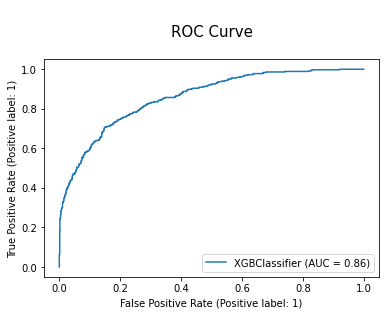

In [ ]:
plt.figure(figsize = (10, 8))

metrics.plot_roc_curve(model_final, X_test, y_test)

plt.title('\nROC Curve\n', fontsize = 15)
plt.savefig('roc_curve.png');

In [ ]:
Threshold = [ ]
Recall = [ ]
Precision = [ ]
ROC_AUC = [ ]
F1 = [ ]
Accuracy = [ ]

i = 0
while i < 1:
  y_pred = model_final.predict_proba(X_test)[:, 1]
  y_pred = [1 if j > i else 0 for j in y_pred]
  Threshold.append(i)
  Recall.append(recall_score(y_test, y_pred))
  Precision.append(precision_score(y_test, y_pred))
  ROC_AUC.append(roc_auc_score(y_test, y_pred))
  F1.append(f1_score(y_test, y_pred))
  Accuracy.append(accuracy_score(y_test, y_pred))
  i += 0.01

result = pd.DataFrame({
    'Threshold': Threshold,
    'Recall': Recall,
    'Precision': Precision,
    'ROC_AUC': ROC_AUC,
    'F1': F1,
    'Accuracy': Accuracy
})

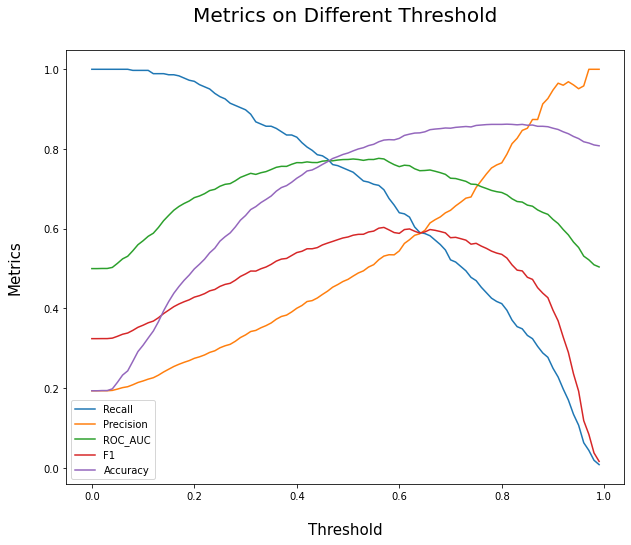

In [ ]:
plt.figure(figsize = (10, 8))
for col in ['Recall', 'Precision', 'ROC_AUC', 'F1', 'Accuracy']:
  sns.lineplot(x = result['Threshold'], y = result[col], label = col)
plt.legend()
plt.title('Metrics on Different Threshold\n', fontsize = 20)
plt.ylabel('Metrics\n', fontsize = 15)
plt.xlabel('\nThreshold', fontsize = 15)
plt.savefig('threshold.png');

In [ ]:
y_pred_proba = model_final.predict_proba(X_test)[:, 1]
y_pred_threshold_result = [ ]
for values in Threshold:
  y_pred_threshold = [1 if i > values else 0 for i in y_pred_proba]
  y_pred_threshold_result.append(y_pred_threshold)

In [ ]:
true_positive = [ ]
false_positive = [ ]
false_negative = [ ]
true_negative = [ ]

for i in y_pred_threshold_result:
  conf_mat = confusion_matrix(y_test, i)
  true_positive.append(conf_mat[1][1])
  false_positive.append(conf_mat[0][1])
  false_negative.append(conf_mat[0][0])
  true_negative.append(conf_mat[1][0])

In [ ]:
result['true_positive'] = true_positive
result['false_positive'] = false_positive
result['false_negative'] = false_negative
result['true_negative'] = true_negative

In [ ]:
result.sample(5)

,Threshold,Recall,Precision,ROC_AUC,F1,Accuracy,true_positive,false_positive,false_negative,true_negative
8,0.08,0.997253,0.208621,0.544770,0.345057,0.267411,363,1377,140,1
92,0.92,0.197802,0.960000,0.597912,0.328018,0.843169,72,3,1514,292
51,0.51,0.741758,0.481283,0.774966,0.583784,0.795322,270,291,1226,94
47,0.47,0.760989,0.453355,0.770409,0.568205,0.776183,277,334,1183,87
88,0.88,0.288462,0.913043,0.640935,0.438413,0.856991,105,10,1507,259


In [ ]:
# Assumptions

profit_per_person = 1
marketing_cost_per_person = 0.05

marketing_eff = 0.5
marketing_out = 0.1

In [ ]:
# awalnya bank akan rugi sejumlah:
# -profit_per_person * y_test.value_counts()[1] (konstan dalam semua kasus)

# kemudian kita prediksi yang bakal exit, dan kita target marketing dengan efektivitas 70%, kita akan meng-save sebesar:
# profit_per_person * (true_positive * marketing_eff)

# kemudian kita anggap ada 10% orang-orang yang awalnya tidak exit, tetapi karena marketing malah exit, kita akan kehilangan sebesar:
# -profit_person_person * (false_positive * marketing_out)

# kemudian kita kurangkan marketing cost, kita akan kehilangan sebesar:
# -marketing_cost_per_person * (true_positive + false_positive)

In [ ]:
def Performance(true_positive, false_positive):
  return profit_per_person * (true_positive * marketing_eff) - profit_per_person * (false_positive * marketing_out) - marketing_cost_per_person * (true_positive + false_positive)

In [ ]:
result['Performance'] = profit_per_person * (result['true_positive'] * marketing_eff) - profit_per_person * (result['false_positive'] * marketing_out) - marketing_cost_per_person * (result['true_positive'] + result['false_positive'])

In [ ]:
result_temp = result.sort_values(['Performance'], ascending = False).head(1)
result_temp

,Threshold,Recall,Precision,ROC_AUC,F1,Accuracy,true_positive,false_positive,false_negative,true_negative,Performance
56,0.56,0.708791,0.522267,0.776611,0.601399,0.818182,258,236,1281,106,80.7


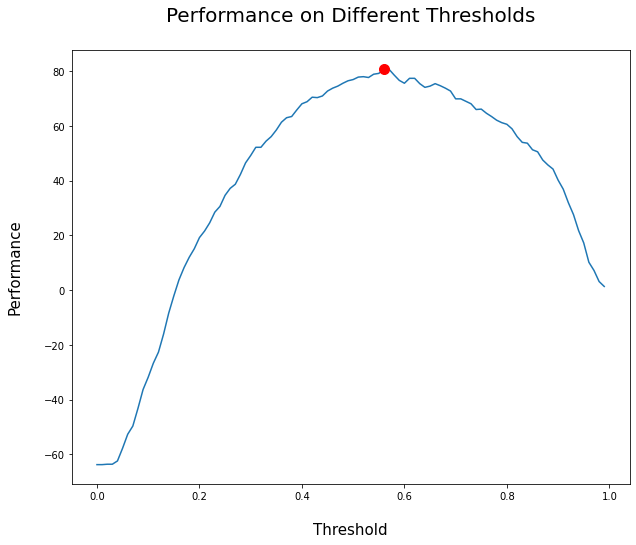

In [ ]:
plt.figure(figsize = (10, 8))
sns.lineplot(x = result['Threshold'], y = result['Performance'])
plt.plot(result_temp['Threshold'], result_temp['Performance'], marker='o', markersize=10, color="red")

plt.title('Performance on Different Thresholds\n', fontsize = 20)
plt.xlabel('\nThreshold', fontsize = 15)
plt.ylabel('Performance\n', fontsize = 15)
plt.savefig('Performance.png');

In [ ]:
threshold = result_temp['Threshold'].max()
threshold

0.5600000000000003

In [ ]:
y_pred_no_threshold = model_final.predict(X_test)

y_pred_proba = model_final.predict_proba(X_test)[:, 1]
y_pred_threshold = [1 if i > threshold else 0 for i in y_pred_proba]

## Classification Report, Accuracy, and ROC_AUC Score

### Without Setting Threshold

In [ ]:
print(classification_report(y_test, y_pred_no_threshold))
print(accuracy_score(y_test, y_pred_no_threshold))

              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1517
           1       0.47      0.75      0.58       364

    accuracy                           0.79      1881
   macro avg       0.70      0.77      0.72      1881
weighted avg       0.84      0.79      0.81      1881

0.7900053163211058


In [ ]:
roc_auc_score(y_test, y_pred_no_threshold)

0.773758212782603

### With Setting Threshold

In [ ]:
print(classification_report(y_test, y_pred_threshold))
print(accuracy_score(y_test, y_pred_threshold))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88      1517
           1       0.52      0.71      0.60       364

    accuracy                           0.82      1881
   macro avg       0.72      0.78      0.74      1881
weighted avg       0.85      0.82      0.83      1881

0.8181818181818182


In [ ]:
roc_auc_score(y_test, y_pred_threshold)

0.7766105022202584

# Business Interpretation

## Feature Importance

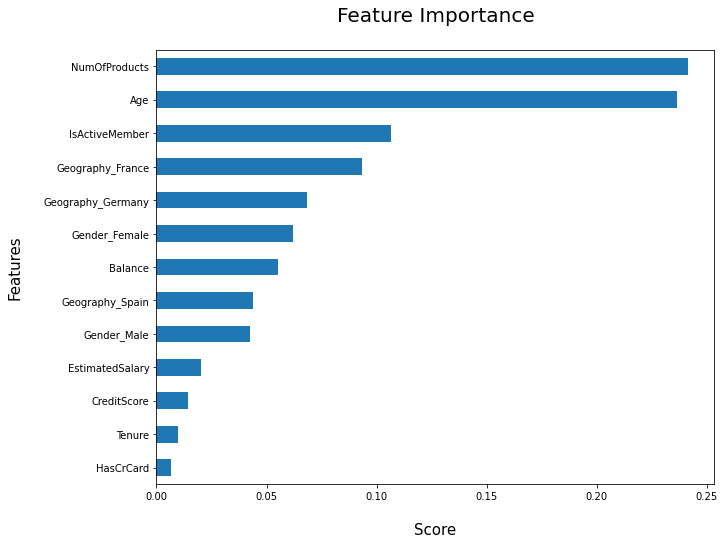

In [ ]:
feat_importances = pd.Series(model_final.feature_importances_, index = X.columns)
ax = feat_importances.nlargest(13).plot(kind='barh', figsize=(10, 8))
ax.invert_yaxis()

plt.title('Feature Importance\n', fontsize = 20)
plt.xlabel('\nScore', fontsize = 15)
plt.ylabel('Features\n', fontsize = 15)
plt.savefig('feature_importance.png');

## SHAP Values

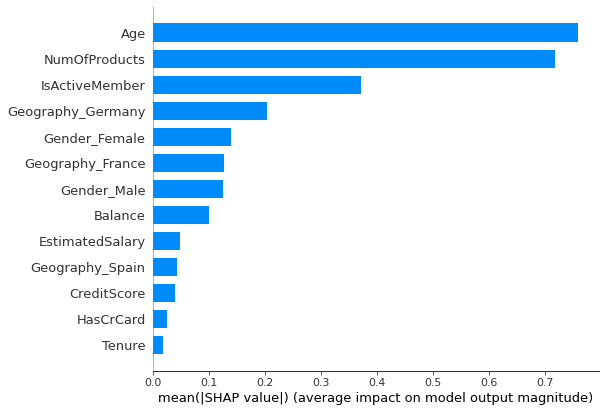

<Figure size 432x288 with 0 Axes>

In [ ]:
explainer = shap.TreeExplainer(model_final)

shap_values = shap.TreeExplainer(model_final).shap_values(X_test)

shap.summary_plot(shap_values, X_train, plot_type="bar")

plt.savefig('shap_bar.png');

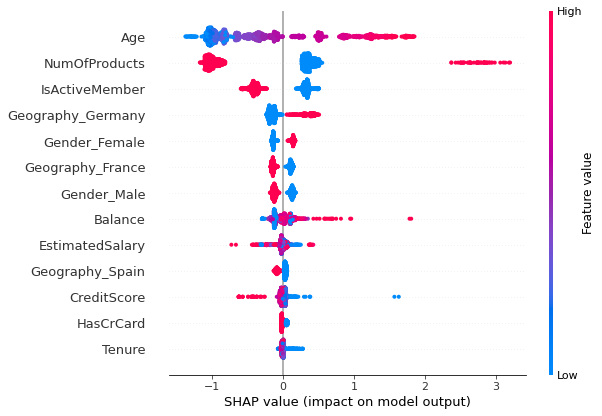

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize = (10,10))

shap.summary_plot(shap_values, X_test)

plt.savefig('shap.png');

# Model Impact

## All-Exit Assumption

In [ ]:
y_pred_exit = [1 for i in y_test]

In [ ]:
confusion_matrix(y_test, y_pred_exit)

array([[   0, 1517],
       [   0,  364]])

In [ ]:
Performance(confusion_matrix(y_test, y_pred_exit)[1][1], confusion_matrix(y_test, y_pred_exit)[0][1])

-63.75000000000003

## All-Stay Assumption

In [ ]:
y_pred_stay = [0 for i in y_test]

In [ ]:
confusion_matrix(y_test, y_pred_stay)

array([[1517,    0],
       [ 364,    0]])

In [ ]:
Performance(confusion_matrix(y_test, y_pred_stay)[1][1], confusion_matrix(y_test, y_pred_stay)[0][1])

0.0

## Using Model to Predict

In [ ]:
y_pred_proba = model_final.predict_proba(X_test)[:, 1]
y_pred_threshold = [1 if i > threshold else 0 for i in y_pred_proba]

In [ ]:
confusion_matrix(y_test, y_pred_threshold)

array([[1281,  236],
       [ 106,  258]])

In [ ]:
Performance(confusion_matrix(y_test, y_pred_threshold)[1][1], confusion_matrix(y_test, y_pred_threshold)[0][1])

80.7